In [0]:
# This is the code for training the models on text datasets without using embedding matrix
# To test the code, run the last 4 cells after loading the model files in the colab environment ie. the cells starting right after the references cell
#set dataset variable to 0 for imdb dataset and 1 for news dataset
# It will give graphs, accuracy and confusion matrix for the 3 models
# To train models again, run all cells from the top

In [0]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten,Conv1D,LSTM,SimpleRNN, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [42]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [43]:
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention

In [0]:
#preprocessing by using regex stopwords and tokenizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

In [0]:
dataset = 0     # 0 for imdb / 1 for news

In [0]:
if dataset == 0:
  modDfObj = pd.read_csv("IMDB Dataset.csv")
if dataset ==1:
  modDfObj = pd.read_csv("NewsDataTop15.csv")

In [0]:
if dataset == 0:
  sentences = list(modDfObj['review'])
if dataset == 1:
  sentences = list(modDfObj['Text'])

X = []
for sentence in sentences:
  TAG_RE = re.compile(r'<[^>]+>')
  sentence = TAG_RE.sub('',sentence) 
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  word_tokens = word_tokenize(sentence) 
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  X.append(filtered_sentence)


In [0]:
if dataset == 0:
  y = modDfObj['sentiment']
  y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
if dataset == 1:
  y = modDfObj['Label']

In [0]:
maxlen = 100

tokenizer = Tokenizer(num_words=7500)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, padding='post', maxlen=maxlen)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=25)

In [51]:
print(X_train[6])
print(len(X_train[6]))
print(X_train.shape)

[ 386   49 2850  142 5447  208  523 3132  333  843    3   66 2433   47
  465    2 4906 6441  565 1528  884  242 6373   55 1457 3349 3549  500
  797  357   16  459  107  517 3665   55 1722   67 1650   55  459  417
 1206  100  459 1199   79  250  160   19  355  291  351   30   25  118
 3502  174 4374 1175 6503 1510  416 7104 1338 3876 3385 2730  448  567
 1718  607  236 1369  157  886  104  162  201   88 3121 1023  301 1388
 3522 1541    8 2913  427 1553  447  119 4153   53 1123  165 7208  106
  669  923]
100
(1591, 100)


In [52]:
 vocabulary_size = len(tokenizer.word_index) + 1
 print(vocabulary_size)

37722


In [0]:
def build_CNN(vocabulary_size,maxlen):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=maxlen))
  model.add(Conv1D(128, 5, activation='relu'))  
  model.add(Conv1D(64, 5, activation='relu'))
  model.add(Conv1D(32, 5, activation='relu'))
  model.add(SeqSelfAttention(attention_activation='sigmoid'))
  model.add(Flatten()) 
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

In [54]:
CNNmodel= build_CNN(vocabulary_size,maxlen)
CNNmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          3772200   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 92, 64)            41024     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 88, 32)            10272     
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, 88, 32)            2113      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2816)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [55]:
if dataset == 0:
  history = CNNmodel.fit(X_train, y_train, batch_size=85, epochs=3, verbose=1, validation_split=0.2)
else:
  history = CNNmodel.fit(X_train, y_train, batch_size=45, epochs=5, verbose=1, validation_split=0.1)

Train on 1431 samples, validate on 160 samples
Epoch 1/5
1431/1431 [==============================] - 4s 3ms/step - loss: 0.6927 - acc: 0.5150 - val_loss: 0.6902 - val_acc: 0.6000
Epoch 2/5
1431/1431 [==============================] - 1s 521us/step - loss: 0.6832 - acc: 0.5297 - val_loss: 0.6765 - val_acc: 0.6000
Epoch 3/5
1431/1431 [==============================] - 1s 519us/step - loss: 0.4655 - acc: 0.7435 - val_loss: 1.0147 - val_acc: 0.4750
Epoch 4/5
1431/1431 [==============================] - 1s 517us/step - loss: 0.0732 - acc: 0.9811 - val_loss: 2.1256 - val_acc: 0.5500
Epoch 5/5
1431/1431 [==============================] - 1s 522us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 2.3538 - val_acc: 0.4813


In [56]:
score = CNNmodel.evaluate(X_test,y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

398/398 [==============================] - 0s 186us/step
Test Score: 2.551361101955625
Test Accuracy: 0.4849246232653383


In [57]:
y_pred = CNNmodel.predict(X_test)
y_pred=np.rint(y_pred)
confusion_matrix(y_pred,y_test)

array([[ 72,  90],
       [115, 121]])

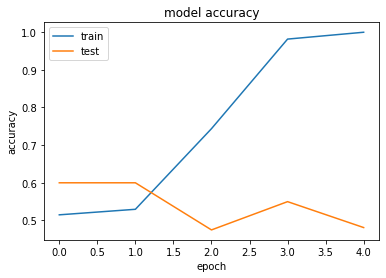

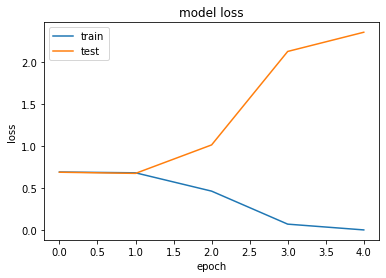

In [58]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [0]:
def build_LSTM(vocabulary_size,maxlen):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 128, input_length=maxlen))
  model.add(Bidirectional(LSTM(64,return_sequences=True)))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

In [60]:
LSTMmodel= build_LSTM(vocabulary_size,maxlen)
LSTMmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 128)          4828416   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,968,513
Trainable params: 4,968,513
Non-trainable params: 0
_________________________________________________________________


In [61]:
if dataset == 0:
  history = LSTMmodel.fit(X_train, y_train, batch_size=85, epochs=3, verbose=1, validation_split=0.2)
else:
  history = LSTMmodel.fit(X_train, y_train, batch_size=45, epochs=5, verbose=1, validation_split=0.1)

Train on 1431 samples, validate on 160 samples
Epoch 1/5
1431/1431 [==============================] - 34s 24ms/step - loss: 0.6925 - acc: 0.5080 - val_loss: 0.6860 - val_acc: 0.6000
Epoch 2/5
1431/1431 [==============================] - 28s 20ms/step - loss: 0.6490 - acc: 0.6226 - val_loss: 0.7196 - val_acc: 0.5438
Epoch 3/5
1431/1431 [==============================] - 28s 20ms/step - loss: 0.2160 - acc: 0.9294 - val_loss: 1.2261 - val_acc: 0.4500
Epoch 4/5
1431/1431 [==============================] - 28s 20ms/step - loss: 0.0302 - acc: 0.9965 - val_loss: 1.5670 - val_acc: 0.4938
Epoch 5/5
1431/1431 [==============================] - 28s 20ms/step - loss: 0.0086 - acc: 0.9993 - val_loss: 1.8640 - val_acc: 0.4625


In [62]:
score = LSTMmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

398/398 [==============================] - 4s 10ms/step
Test Score: 1.9138858234463025
Test Accuracy: 0.46984924623115576


In [63]:
y_pred = LSTMmodel.predict(X_test)
y_pred=np.rint(y_pred)
confusion_matrix(y_pred,y_test)

array([[ 46,  70],
       [141, 141]])

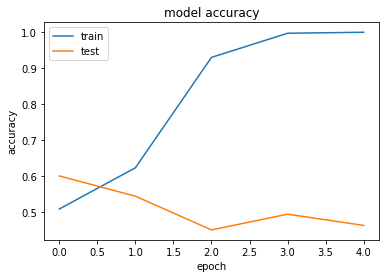

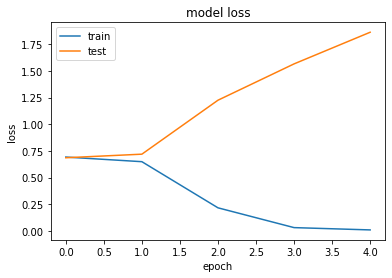

In [64]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [0]:
def build_RNN(vocabulary_size,maxlen):
  model = Sequential()
  embedding_layer = Embedding(vocabulary_size, 100, input_length=maxlen , trainable=False)
  model.add(embedding_layer)
  model.add(Bidirectional(SimpleRNN(128, activation='relu',return_sequences=True)))
  model.add(Bidirectional(SimpleRNN(32, activation='relu')))
  #model.add(SeqSelfAttention(attention_activation='sigmoid'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

In [66]:
RNNmodel= build_RNN(vocabulary_size,maxlen)
RNNmodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3772200   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 256)          58624     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                18496     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 3,850,377
Trainable params: 78,177
Non-trainable params: 3,772,200
_________________________________________________________________


In [67]:
if dataset == 0:
  history = RNNmodel.fit(X_train, y_train, batch_size=85, epochs=6, verbose=1, validation_split=0.2)
else:
  history = RNNmodel.fit(X_train, y_train, batch_size=45, epochs=5, verbose=1, validation_split=0.1)

Train on 1431 samples, validate on 160 samples
Epoch 1/5
1431/1431 [==============================] - 14s 9ms/step - loss: 0.6934 - acc: 0.5136 - val_loss: 0.6891 - val_acc: 0.6000
Epoch 2/5
1431/1431 [==============================] - 9s 6ms/step - loss: 0.6866 - acc: 0.5318 - val_loss: 0.6767 - val_acc: 0.6000
Epoch 3/5
1431/1431 [==============================] - 9s 6ms/step - loss: 0.6751 - acc: 0.5730 - val_loss: 0.6941 - val_acc: 0.4875
Epoch 4/5
1431/1431 [==============================] - 9s 6ms/step - loss: 0.6254 - acc: 0.6855 - val_loss: 0.7109 - val_acc: 0.5188
Epoch 5/5
1431/1431 [==============================] - 8s 6ms/step - loss: 0.4949 - acc: 0.7834 - val_loss: 0.7838 - val_acc: 0.5063


In [68]:
score = RNNmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

398/398 [==============================] - 2s 5ms/step
Test Score: 0.8440111725773644
Test Accuracy: 0.4773869348231273


In [69]:
y_pred = RNNmodel.predict(X_test)
y_pred=np.rint(y_pred)
confusion_matrix(y_pred,y_test)

array([[ 88, 109],
       [ 99, 102]])

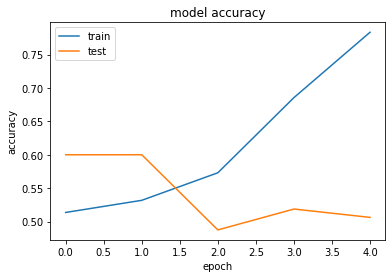

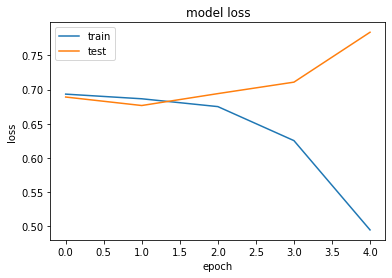

In [70]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [0]:

word_index= tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
e = CNNmodel.layers[0]
weights = e.get_weights()[0]

In [0]:
#save vector files
import io

out_v = io.open('vecsnews'+str(dataset)+'.tsv', 'w', encoding='utf-8')
out_m = io.open('metanews'+str(dataset)+ '.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocabulary_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
#save models
RNNmodel.save('rnn_without_embed_news.h5')
CNNmodel.save('cnn_without_embed_news.h5')
LSTMmodel.save('lstm_without_embed_news.h5')

In [0]:
# References:
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://keras.io/examples/imdb_bidirectional_lstm/
# https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/AXwJI/implementing-lstms-in-code
# https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/Sydkf/notebook-for-lesson-2
# https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
# https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
# https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e
# https://medium.com/@Petuum/embeddings-a-matrix-of-meaning-4de877c9aa27
#https://github.com/tensorflow/tensorflow/issues/23698
#https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
#https://jovianlin.io/saving-loading-keras-models/

In [75]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten,Conv1D,LSTM,SimpleRNN, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import nltk
nltk.download('all')
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

398/398 [==============================] - 2s 4ms/step
Test Score: 2.551361101955625
Test Accuracy: 0.4849246232653383
[[ 72  90]
 [115 121]]


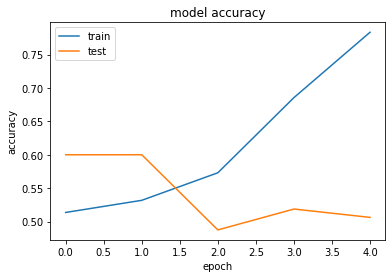

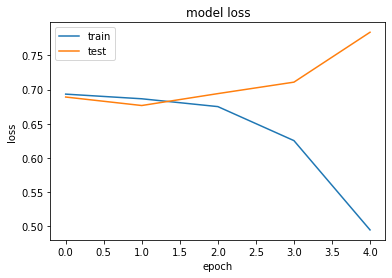

In [76]:
CNNmodel = load_model('cnn_without_embed_news.h5', custom_objects = {'SeqSelfAttention':SeqSelfAttention})
score = CNNmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
y_pred = CNNmodel.predict(X_test)
y_pred=np.rint(y_pred)
print(confusion_matrix(y_pred,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

398/398 [==============================] - 6s 16ms/step
Test Score: 1.9138858234463025
Test Accuracy: 0.46984924623115576
[[ 46  70]
 [141 141]]


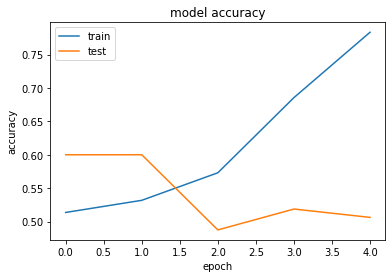

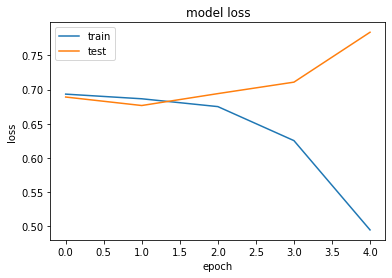

In [77]:
LSTMmodel = load_model('lstm_without_embed_news.h5', custom_objects = {'SeqSelfAttention':SeqSelfAttention})
score = LSTMmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
y_pred = LSTMmodel.predict(X_test)
y_pred=np.rint(y_pred)
print(confusion_matrix(y_pred,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

398/398 [==============================] - 4s 10ms/step
Test Score: 0.8440111725773644
Test Accuracy: 0.4773869348231273
[[ 88 109]
 [ 99 102]]


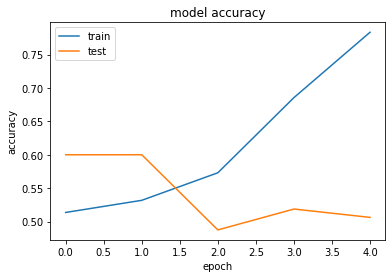

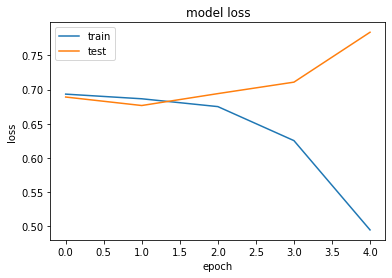

In [78]:
RNNmodel = load_model('rnn_without_embed_news.h5', custom_objects = {'SeqSelfAttention':SeqSelfAttention})
score = RNNmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
y_pred = RNNmodel.predict(X_test)
y_pred=np.rint(y_pred)
print(confusion_matrix(y_pred,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()